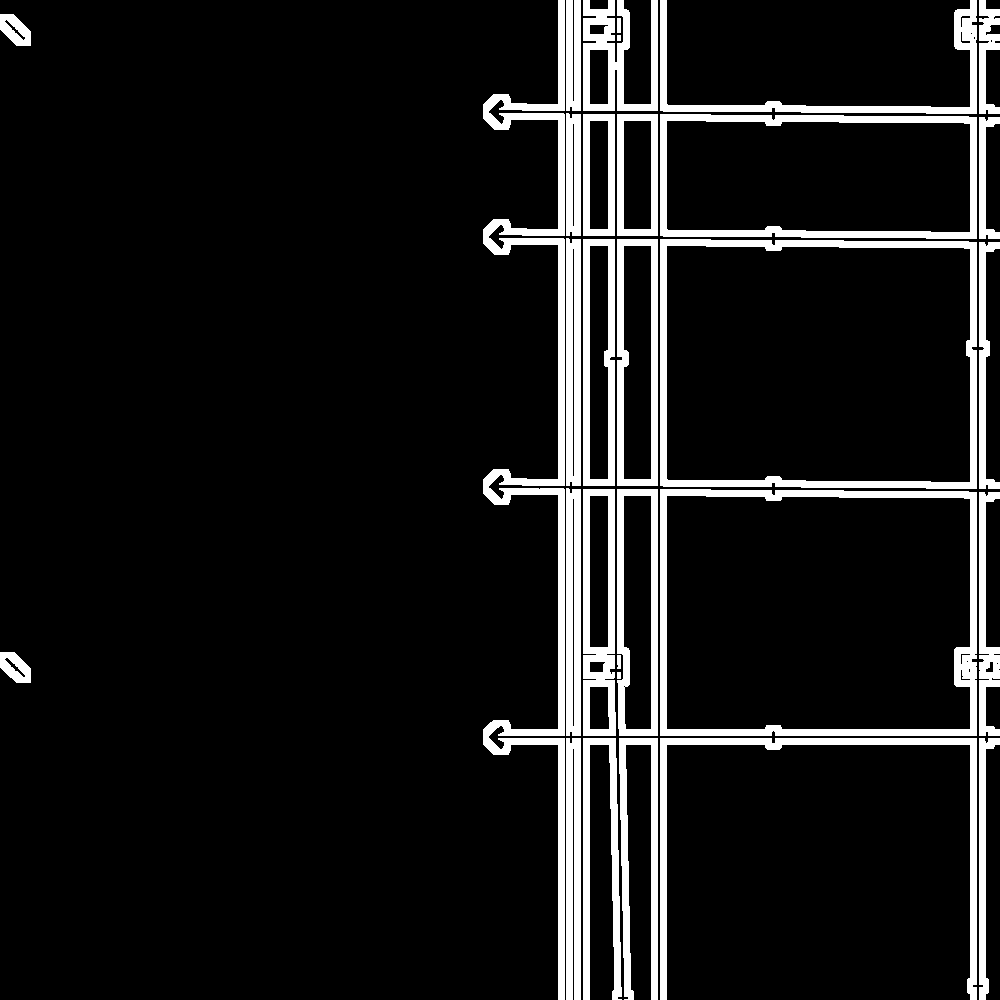

In [1]:
import numpy as np
from PIL import Image
import cv2

img = cv2.imread("/home/sadid/PycharmProjects/sgs-drawing-analysis/data/original.png")
height, width = img.shape[:2]

tile = img[2000:3000, 2000:3000].copy()

gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((2, 2), np.uint8)
erode = cv2.erode(thresh, kernel)

bw = cv2.adaptiveThreshold(
    erode, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    15, 3
)

Image.fromarray(bw)

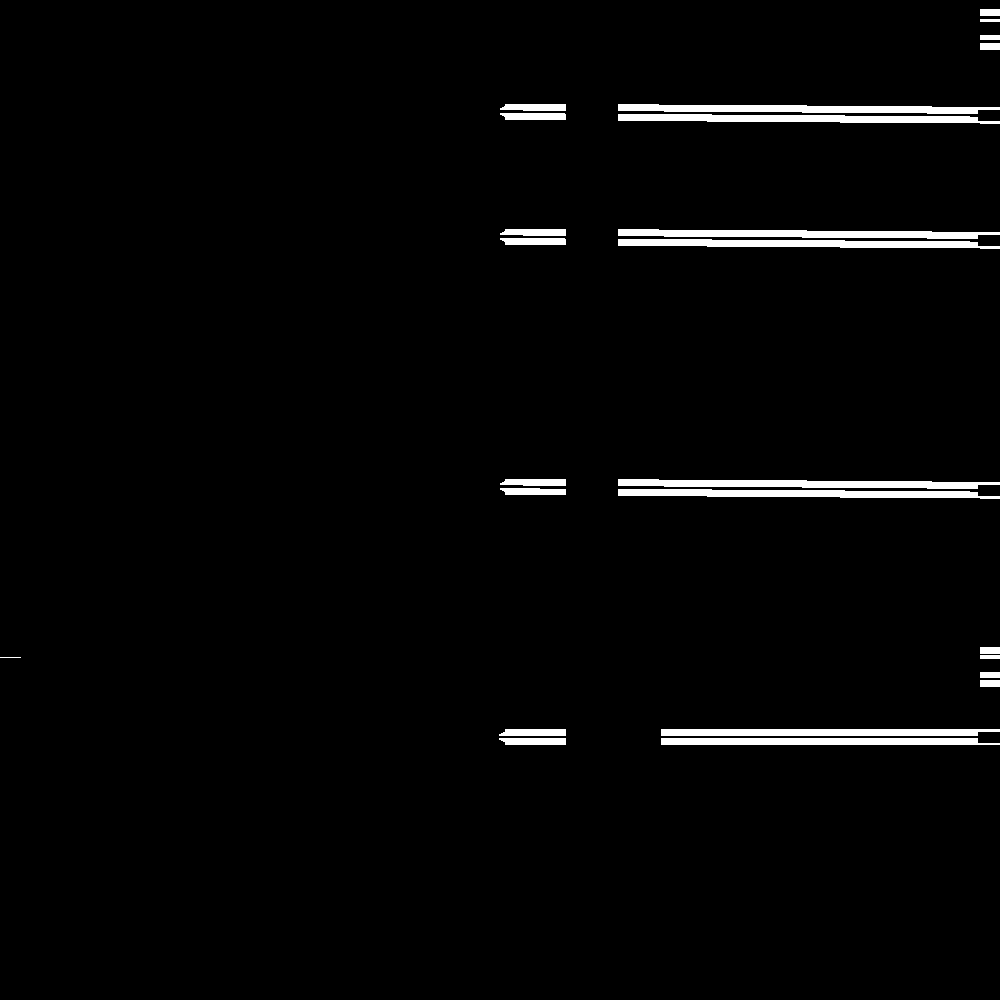

In [2]:
kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (40, 1)   # wide and flat
)

horizontal = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
horizontal = cv2.morphologyEx(
    horizontal,
    cv2.MORPH_CLOSE,
    cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
)
Image.fromarray(horizontal)

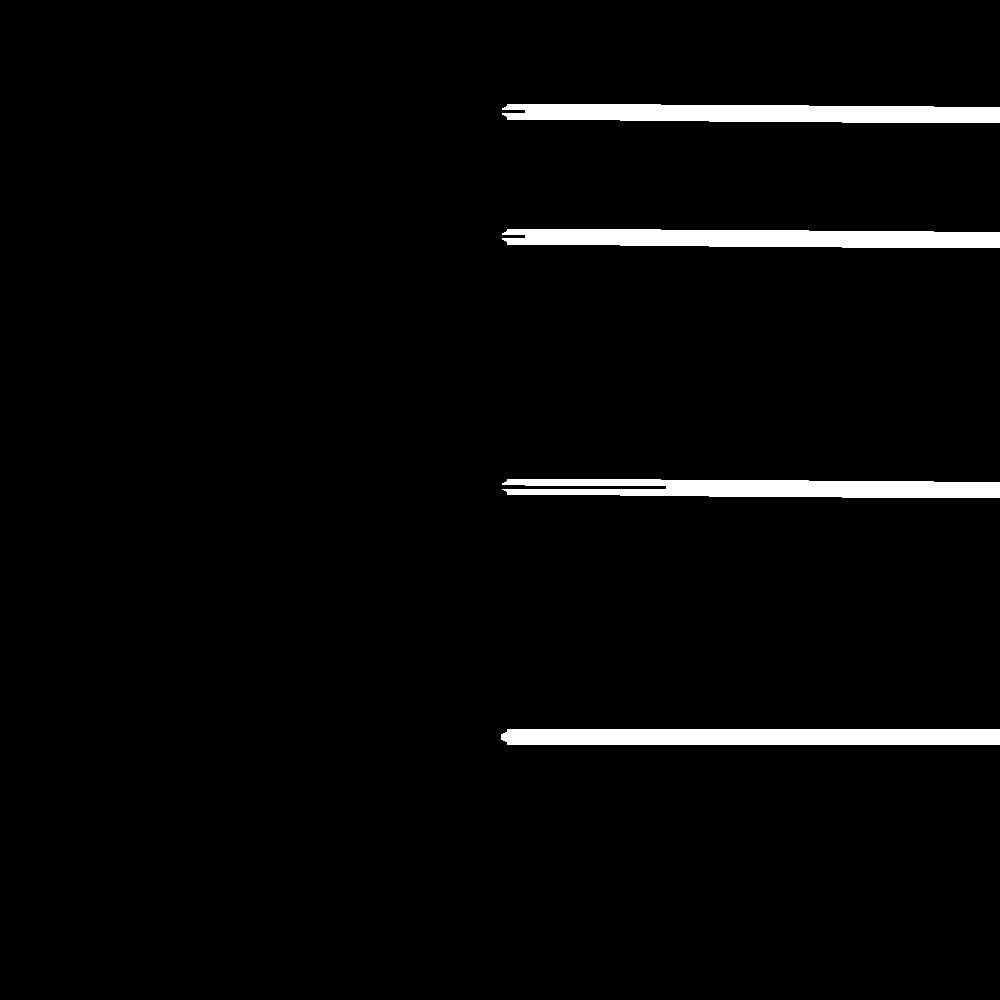

In [3]:
bridge_kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (100, 3)   # width > expected vertical-line thickness
)

bw_bridged = cv2.morphologyEx(
    horizontal,
    cv2.MORPH_CLOSE,
    bridge_kernel
)

extract_kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (60, 1)
)

horizontal = cv2.morphologyEx(
    bw_bridged,
    cv2.MORPH_OPEN,
    extract_kernel
)

Image.fromarray(horizontal)

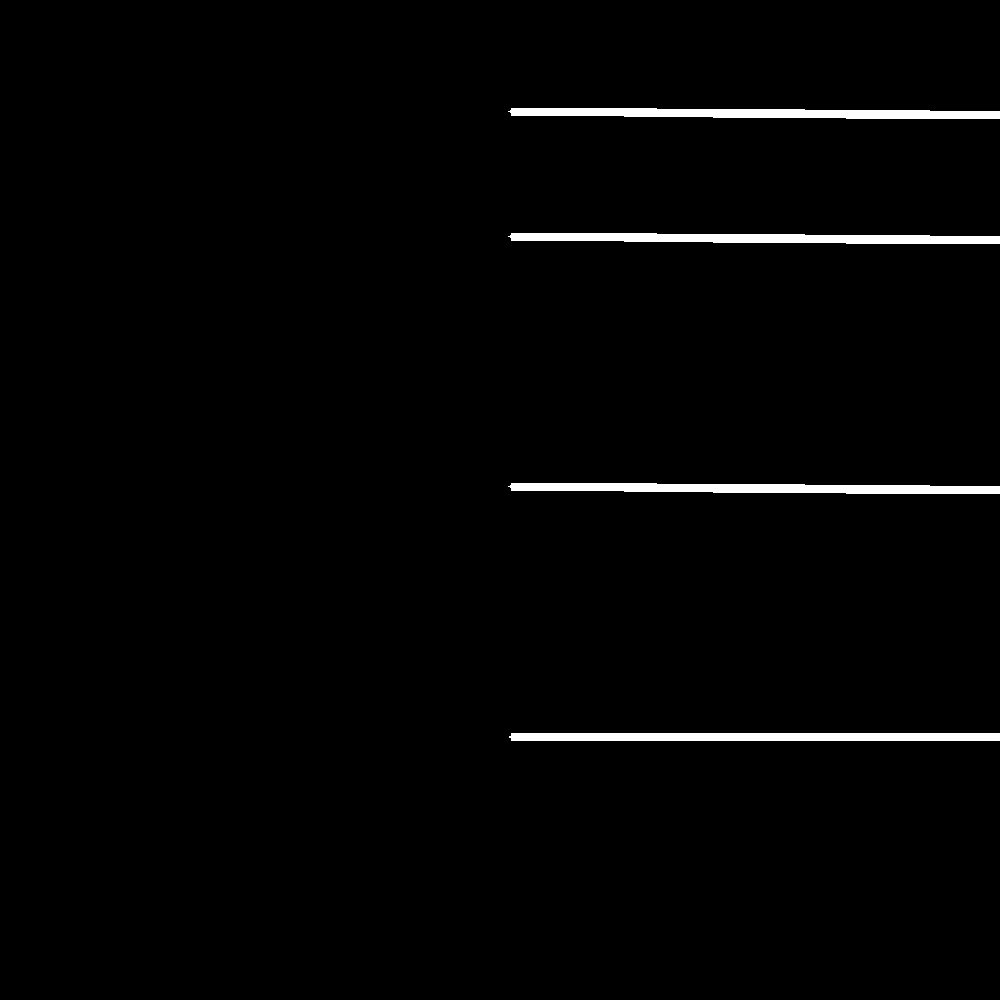

In [4]:
kernel = np.ones((5, 5), np.uint8)
dilate = cv2.dilate(horizontal, kernel)
dilate = cv2.erode(dilate, kernel, iterations=3)

Image.fromarray(dilate)

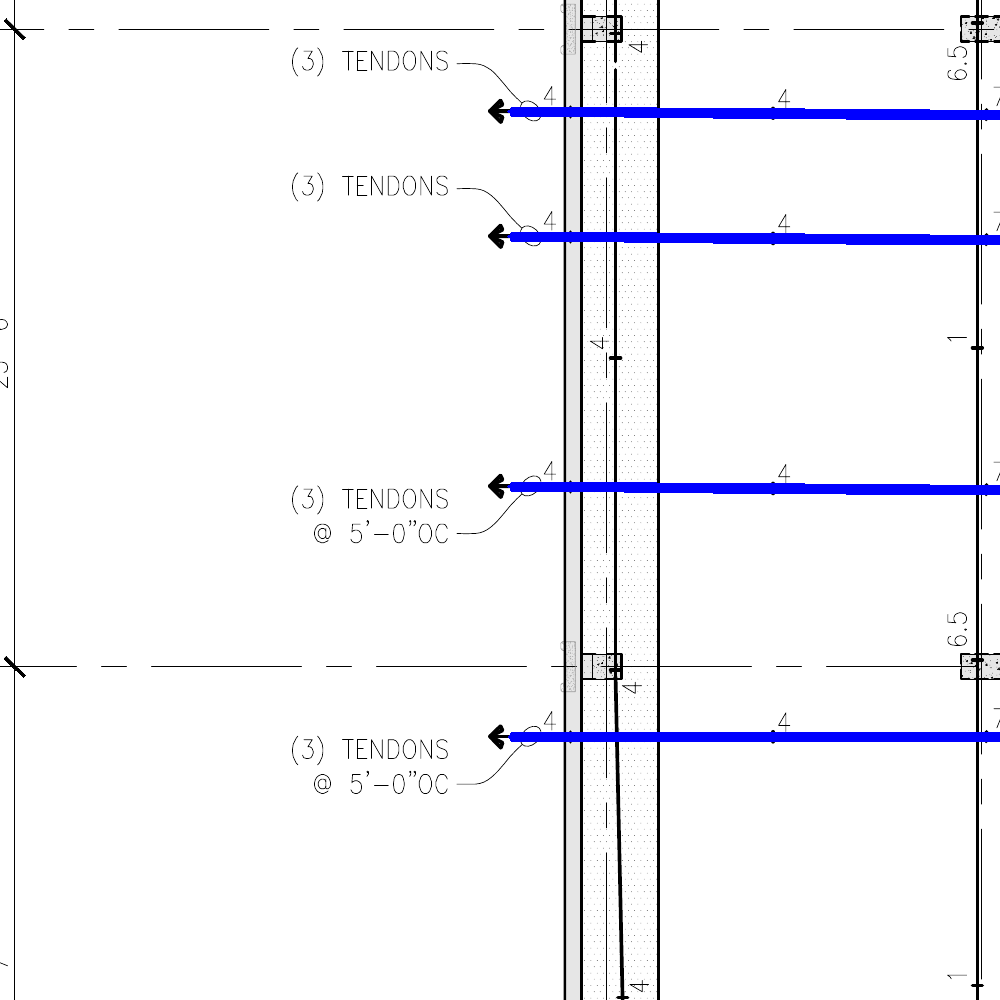

In [5]:
lines = cv2.HoughLinesP(
    dilate,
    rho=1,
    theta=np.pi / 180,
    threshold=100,
    minLineLength=100,
    maxLineGap=10
)

results = []
image_copy = tile.copy()
if lines is not None:
    for l in lines:
        x1, y1, x2, y2 = l[0]

        # keep horizontal or vertical
        if abs(x1 - x2) < 10 or abs(y1 - y2) < 10:
            results.append((x1, y1, x2, y2))
            cv2.line(image_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

Image.fromarray(image_copy)

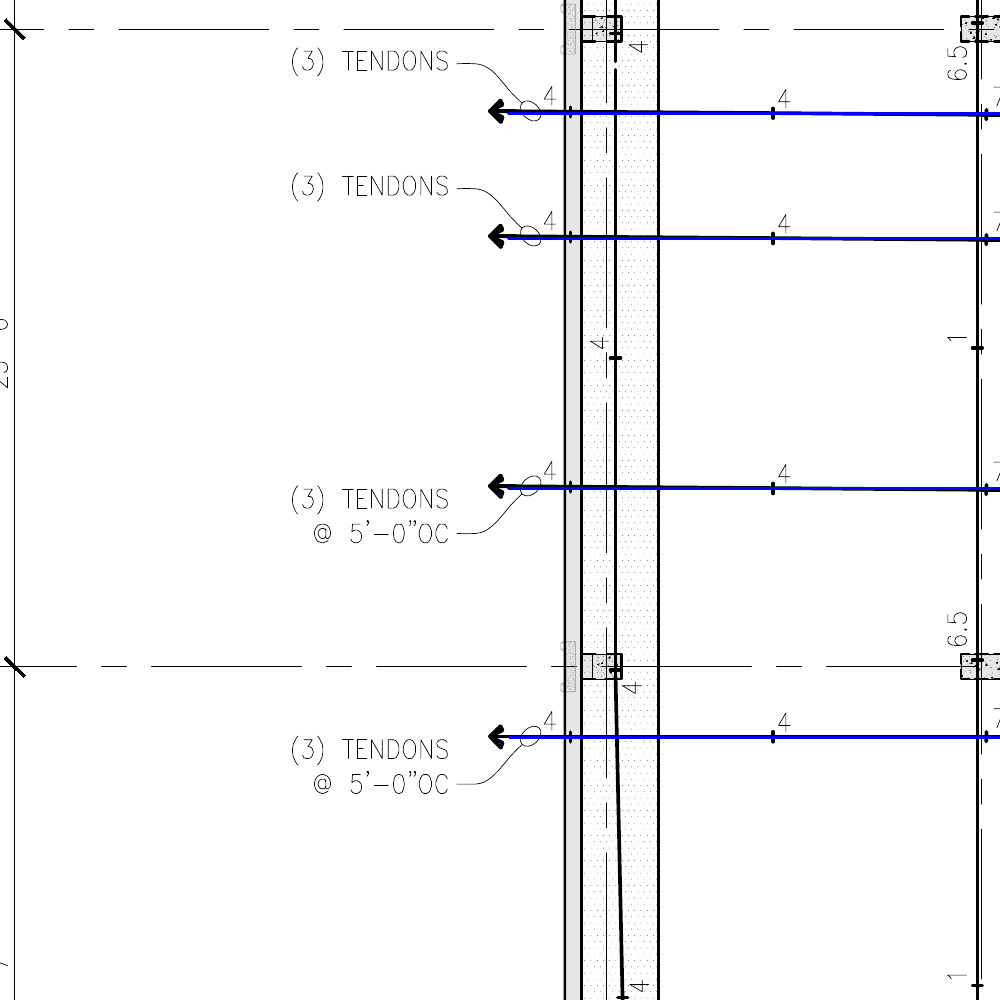

In [7]:
contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

final_lines = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 100 and h < 15:
        final_lines.append((x, y + h//2, x + w, y + h//2))

results = []
image_copy = tile.copy()
if final_lines is not None:
    for l in final_lines:
        x1, y1, x2, y2 = l

        # keep horizontal or vertical
        if abs(x1 - x2) < 10 or abs(y1 - y2) < 10:
            results.append((x1, y1, x2, y2))
            cv2.line(image_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

Image.fromarray(image_copy)